In [11]:
import os
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F

In [12]:
raw = pd.read_csv('../data/BTC/BTC_Book_0.zip', compression = 'zip', parse_dates = True, index_col = 0)
prices = raw[raw.columns[1::3]]
sizes = raw[raw.columns[2::3]]
trades = raw[raw.columns[3::3]]

In [13]:
feature_data = pd.DataFrame((prices['Bid_1_Price'] + prices['Ask_1_Price'])/2, columns = ['Mid_Price'])
feature_data['Spread'] = prices['Ask_1_Price'] - prices['Bid_1_Price']
feature_data['Bid_Dist'] = prices['Bid_1_Price'] - prices['Bid_50_Price']
feature_data['Ask_Dist'] = prices['Ask_50_Price'] - prices['Ask_1_Price']

feature_data['Level_1_Size_IMB'] = sizes['Ask_1_Size'] - sizes['Bid_1_Size']
feature_data['Ask_1_Size'] = sizes['Ask_1_Size']
feature_data['Bid_1_Size'] = sizes['Bid_1_Size']

bid_sizes = sizes[sizes.columns[:50]]
feature_data['Cumu_Bids'] = bid_sizes.cumsum(axis=1)['Bid_50_Size']

ask_sizes = sizes[sizes.columns[50:]]
feature_data['Cumu_Asks'] = ask_sizes.cumsum(axis=1)['Ask_50_Size']

feature_data['Cumu_Size_IMB'] = feature_data['Cumu_Asks'] - feature_data['Cumu_Bids']

feature_data.head()

,Mid_Price,Spread,Bid_Dist,Ask_Dist,Level_1_Size_IMB,Ask_1_Size,Bid_1_Size,Cumu_Bids,Cumu_Asks,Cumu_Size_IMB
Timestamp,,,,,,,,,,
2020-04-03 17:06:34.424123-04:00,6708.695,0.01,28.69,34.36,0.747936,1.194986,0.447050,101.206556,89.55978,-11.646776
2020-04-03 17:06:35.388369-04:00,6708.695,0.01,28.69,34.36,0.778807,1.194986,0.416178,101.175685,89.55978,-11.615905
2020-04-03 17:06:36.414534-04:00,6708.695,0.01,28.69,34.36,0.778807,1.194986,0.416178,101.175685,89.55978,-11.615905
2020-04-03 17:06:37.400652-04:00,6708.695,0.01,28.69,34.36,0.778807,1.194986,0.416178,101.175685,89.55978,-11.615905
2020-04-03 17:06:38.408623-04:00,6708.695,0.01,28.69,34.36,0.778807,1.194986,0.416178,101.175685,89.55978,-11.615905


In [14]:
feature_data['return'] = feature_data['Mid_Price'].diff(1)
feature_data['return_target'] = feature_data['return'].shift(-1)

In [16]:
def return_cat(x):
    if x == 0:
        return 0
    if x > 0:
        return 1
    if x < 0:
        return -1

In [17]:
feature_data['target_cat'] = feature_data['return_target'].apply(return_cat)
feature_data = feature_data.dropna()

In [18]:
feature_data['Spread'] = np.log(feature_data['Spread'].values)
feature_data['Bid_1_Size'] = np.log(feature_data['Bid_1_Size'].values)
feature_data['Ask_1_Size'] = np.log(feature_data['Ask_1_Size'].values)
feature_data['Bid_Dist'] = np.log(feature_data['Bid_Dist'].values)
feature_data['Ask_Dist'] = np.log(feature_data['Ask_Dist'].values)

[ 6.67200500e+03 -4.60517019e+00  1.83896107e+00  2.42568729e+00
 -2.53678015e+01 -1.77275336e+01 -1.56480920e+01  1.03265411e+01
  1.65309761e+01 -1.21542457e+02]


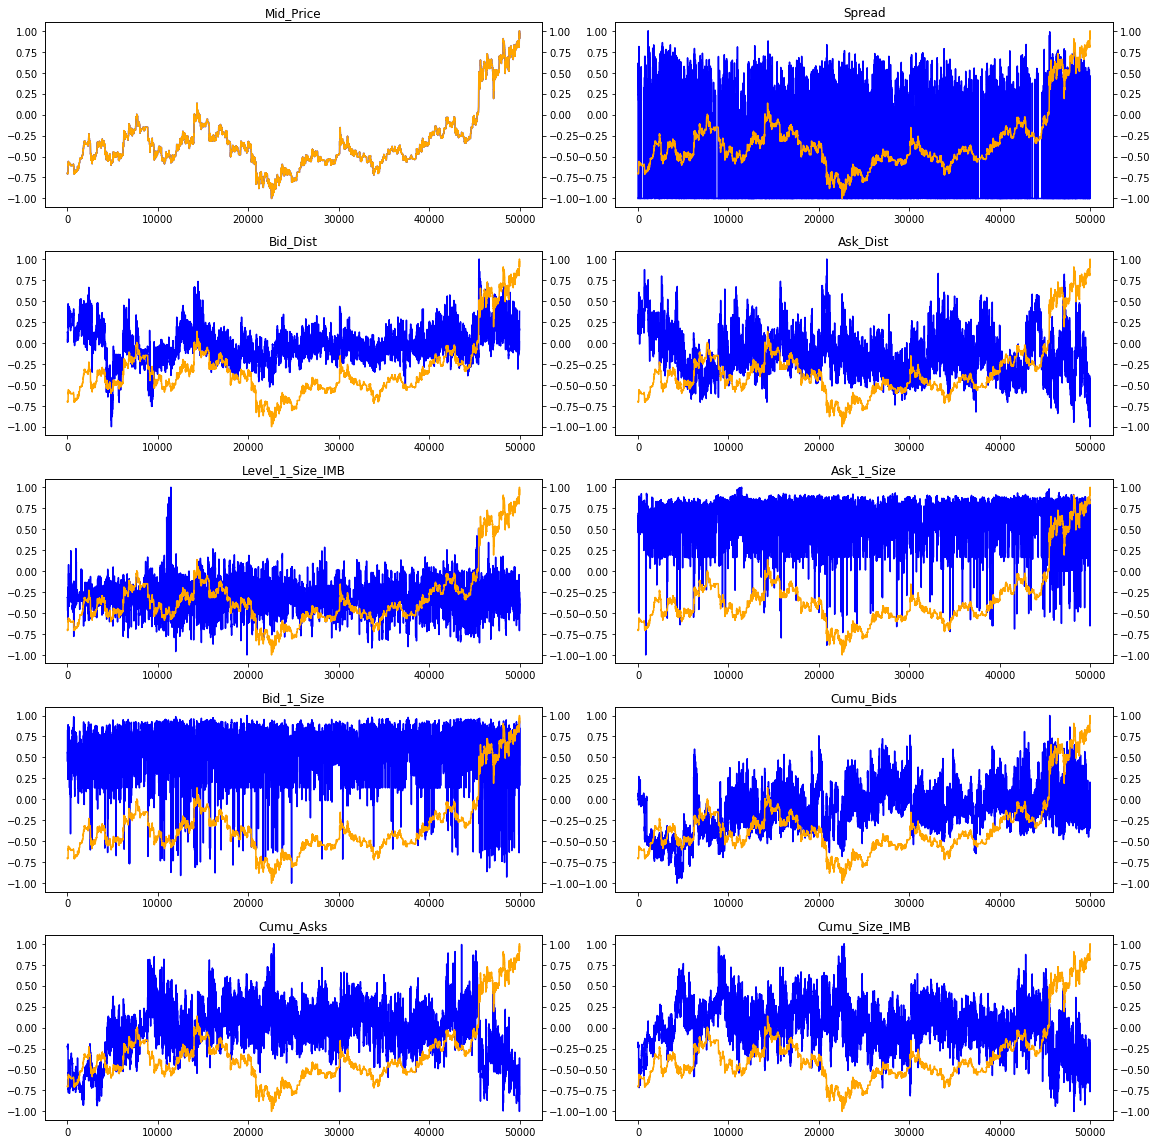

In [19]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

feature_scaler = MinMaxScaler(feature_range=(-1, 1))

feature_to_scale = feature_data.drop(columns = ['return', 'return_target', 'target_cat'])

#mid_price_reshape = np.expand_dims(mid_price.values,1)
feature_scaler.fit(feature_to_scale)
print(feature_scaler.data_min_)

feature_norm = feature_scaler.transform(feature_to_scale)

fig, ax = plt.subplots(5,2, figsize = (16,16))

for i in range(5):
    for j in range(2):
        ax[i][j].plot(feature_norm[:,2*i+j], color = 'blue')
        ax[i][j].set_title(feature_to_scale.columns[2*i+j])
        
        ax_other = ax[i][j].twinx()
        ax_other.plot(feature_norm[:,0], color = 'orange')
        
fig.tight_layout()

#check proper scaling with data_min_

In [26]:
def rolling_window(a, window_size):
    shape = (a.shape[0] - window_size + 1, window_size) + a.shape[1:]
    strides = (a.strides[0],) + a.strides
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


subsets = rolling_window(feature_norm,10)
X = subsets[:len(subsets)-1]
Y = subsets[1:][:,-1,0]

X = torch.Tensor(X)
X = X[88:]

print(X.shape)

torch.Size([49900, 10, 10])


In [27]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoder.fit(feature_data['target_cat'].values.reshape(-1,1))

cat = encoder.transform(feature_data['target_cat'].values.reshape(-1,1)).toarray()

Y = torch.Tensor(cat[10:])
Y = Y[88:]
Y = Y.type(torch.LongTensor)
print(Y.dtype)
print(Y.shape)

torch.int64
torch.Size([49900, 3])


In [28]:
X = X.numpy()
Y = Y.numpy()

In [53]:
import keras

model = keras.models.Sequential()
model.add(keras.layers.LSTM(50))
model.add(keras.layers.Dense(64, activation = 'relu'))
model.add(keras.layers.Dense(3, activation = 'softmax'))

model.compile(optimizer = keras.optimizers.Adam(lr = 0.05, decay = 1e-2),
              loss='categorical_crossentropy',
              metrics = ['categorical_accuracy'])

history = model.fit(x=X,
                    y=Y,
                    batch_size=100,
                    epochs=25,
                    verbose=1)
                    #callbacks=callbacks,
                    #validation_data=(X_test, y_test))

model.summary()

Epoch 1/25
49900/49900 [==============================] - 3s 65us/step - loss: 0.5309 - categorical_accuracy: 0.7914
Epoch 2/25
49900/49900 [==============================] - 3s 60us/step - loss: 0.4625 - categorical_accuracy: 0.8082
Epoch 3/25
49900/49900 [==============================] - 3s 59us/step - loss: 0.4535 - categorical_accuracy: 0.8123
Epoch 4/25
49900/49900 [==============================] - 3s 58us/step - loss: 0.4482 - categorical_accuracy: 0.8143
Epoch 5/25
49900/49900 [==============================] - 3s 58us/step - loss: 0.4443 - categorical_accuracy: 0.8150
Epoch 6/25
49900/49900 [==============================] - 3s 59us/step - loss: 0.4415 - categorical_accuracy: 0.8160
Epoch 7/25
49900/49900 [==============================] - 3s 58us/step - loss: 0.4390 - categorical_accuracy: 0.8169
Epoch 8/25
49900/49900 [==============================] - 3s 61us/step - loss: 0.4368 - categorical_accuracy: 0.8172
Epoch 9/25
49900/49900 [==============================] - 3s 58u

[[ 2432.  2088.  1364.]
 [  893. 36721.   608.]
 [ 1893.  2003.  1898.]]


Text(51.0, 0.5, 'True Label')

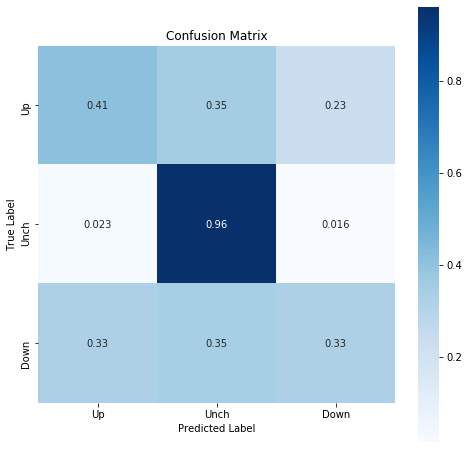

In [56]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.argmax(Y,1), np.argmax(model.predict(X),1))
cm = cm.astype(float)

print(cm)

cm[0,:] = np.true_divide(cm[0,:], cm[0,:].sum())
cm[1,:] = np.true_divide(cm[1,:], cm[1,:].sum())
cm[2,:] = np.true_divide(cm[2,:], cm[2,:].sum())


import seaborn as sns

fig, axs = plt.subplots(1, figsize = (8,8))
axs = sns.heatmap(cm, xticklabels=['Up','Unch', 'Down'], 
                  yticklabels=['Up','Unch', 'Down'], annot = True,square=True, cmap = plt.cm.Blues)
axs.set_title("Confusion Matrix")
axs.set_xlabel('Predicted Label')
axs.set_ylabel('True Label')

In [243]:
class RecurrentModel(nn.Module):
    def __init__(self, INPUT_SIZE, HIDDEN_SIZE, N_LAYERS, OUTPUT_SIZE):
        super(RecurrentModel, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size = INPUT_SIZE,
            hidden_size = HIDDEN_SIZE, # number of hidden units
            num_layers = N_LAYERS, # number of layers
            batch_first = True
        )
        
        self.out = nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE)
            
    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        # r_out, (h_n, h_c) = self.rnn(x, None) # None represents zero initial hidden state
            
        r_out, h = self.lstm(x, None) # None represents zero initial hidden state
            
        # to choose last time step of output, use -1 in center index
            
        out = self.out(r_out[:, -1, :])
        return out

    
n_hidden = 20
price_model = RecurrentModel(10, n_hidden, 1, 3)
price_model(X).shape

torch.Size([49900, 3])

In [244]:
def train_model(model, LR, n_epochs, X_BATCH, Y_BATCH):
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)   # optimize all rnn parameters
    loss_func = nn.CrossEntropyLoss()  

    all_losses = []
    all_accuracies = []

    for epoch in range(1,n_epochs+1):
        if epoch % 4 == 0:
            for param in optimizer.param_groups:
                param['lr'] = param['lr']/2 

        for i in range(len(X_BATCH)):

            train_x = X_BATCH[i]
            train_y = Y_BATCH[i]

            output = model(train_x)
            loss = loss_func(output, torch.max(train_y,1)[1])                # compute loss                      
            optimizer.zero_grad()                            # clear gradients for this training step
            loss.backward()                                  # backpropagation, compute gradients
            optimizer.step()                                 # apply gradient step

            all_losses.append(loss.item())                   #track loss

    #     #compute accuracy
    #     acc_output = rnn(b_x)
    #     pred_y = torch.max(acc_output,1)[1].data.numpy().squeeze()
    #     target = torch.max(b_y,1)[1].data.numpy().squeeze()
    #     train_accuracy = sum(pred_y==target)/b_y.size(0)

            #print info
            print("Epoch: ", epoch, "| train loss: %.4f" % loss.item())#, "| train accuracy: %.8f" % train_accuracy)

    return all_losses, all_accuracies

Epoch:  1 | train loss: 1.0096
Epoch:  1 | train loss: 0.6169
Epoch:  1 | train loss: 0.8775
Epoch:  1 | train loss: 0.8933
Epoch:  1 | train loss: 0.9709
Epoch:  1 | train loss: 0.9346
Epoch:  1 | train loss: 0.8876
Epoch:  1 | train loss: 0.9509
Epoch:  1 | train loss: 0.9594
Epoch:  1 | train loss: 0.8964
Epoch:  1 | train loss: 0.8245
Epoch:  1 | train loss: 0.7395
Epoch:  1 | train loss: 0.7919
Epoch:  1 | train loss: 0.7950
Epoch:  1 | train loss: 0.6122
Epoch:  1 | train loss: 0.7210
Epoch:  1 | train loss: 0.4516
Epoch:  1 | train loss: 0.4471
Epoch:  1 | train loss: 0.6181
Epoch:  1 | train loss: 0.4945
Epoch:  1 | train loss: 0.5340
Epoch:  1 | train loss: 0.4094
Epoch:  1 | train loss: 0.3008
Epoch:  1 | train loss: 0.3660
Epoch:  1 | train loss: 0.8107
Epoch:  1 | train loss: 0.9599
Epoch:  1 | train loss: 0.7632
Epoch:  1 | train loss: 0.9424
Epoch:  1 | train loss: 0.8034
Epoch:  1 | train loss: 0.5761
Epoch:  1 | train loss: 0.3848
Epoch:  1 | train loss: 0.5509
Epoch:  

Epoch:  3 | train loss: 0.5456
Epoch:  3 | train loss: 0.5452
Epoch:  3 | train loss: 0.2393
Epoch:  3 | train loss: 0.2093
Epoch:  3 | train loss: 0.4703
Epoch:  3 | train loss: 0.7388
Epoch:  3 | train loss: 0.3870
Epoch:  3 | train loss: 0.6462
Epoch:  3 | train loss: 0.4417
Epoch:  3 | train loss: 0.4122
Epoch:  3 | train loss: 0.4421
Epoch:  3 | train loss: 0.3590
Epoch:  3 | train loss: 0.5126
Epoch:  3 | train loss: 0.3836
Epoch:  3 | train loss: 0.2278
Epoch:  3 | train loss: 0.1966
Epoch:  3 | train loss: 0.2869
Epoch:  3 | train loss: 0.5088
Epoch:  3 | train loss: 0.6550
Epoch:  3 | train loss: 0.6454
Epoch:  3 | train loss: 0.4529
Epoch:  3 | train loss: 0.6019
Epoch:  3 | train loss: 0.6162
Epoch:  3 | train loss: 0.5955
Epoch:  3 | train loss: 0.5827
Epoch:  3 | train loss: 0.5682
Epoch:  3 | train loss: 0.5260
Epoch:  4 | train loss: 0.3390
Epoch:  4 | train loss: 0.4260
Epoch:  4 | train loss: 0.6680
Epoch:  4 | train loss: 0.6981
Epoch:  4 | train loss: 0.7545
Epoch:  

Epoch:  6 | train loss: 0.5271
Epoch:  6 | train loss: 0.6621
Epoch:  6 | train loss: 0.5220
Epoch:  6 | train loss: 0.4662
Epoch:  6 | train loss: 0.7232
Epoch:  6 | train loss: 0.5225
Epoch:  6 | train loss: 0.6798
Epoch:  6 | train loss: 0.5584
Epoch:  6 | train loss: 0.4321
Epoch:  6 | train loss: 0.3878
Epoch:  6 | train loss: 0.3538
Epoch:  6 | train loss: 0.7235
Epoch:  6 | train loss: 0.6141
Epoch:  6 | train loss: 0.5240
Epoch:  6 | train loss: 0.6332
Epoch:  6 | train loss: 0.3049
Epoch:  6 | train loss: 0.5008
Epoch:  6 | train loss: 0.4597
Epoch:  6 | train loss: 0.2596
Epoch:  6 | train loss: 0.5030
Epoch:  6 | train loss: 0.6262
Epoch:  6 | train loss: 0.7326
Epoch:  6 | train loss: 0.4751
Epoch:  6 | train loss: 0.4051
Epoch:  6 | train loss: 0.2934
Epoch:  6 | train loss: 0.3646
Epoch:  6 | train loss: 0.4420
Epoch:  6 | train loss: 0.5086
Epoch:  6 | train loss: 0.5460
Epoch:  6 | train loss: 0.1905
Epoch:  6 | train loss: 0.3701
Epoch:  6 | train loss: 0.3110
Epoch:  

Epoch:  9 | train loss: 0.7347
Epoch:  9 | train loss: 0.6518
Epoch:  9 | train loss: 0.6338
Epoch:  9 | train loss: 0.5236
Epoch:  9 | train loss: 0.5593
Epoch:  9 | train loss: 0.4597
Epoch:  9 | train loss: 0.5203
Epoch:  9 | train loss: 0.5019
Epoch:  9 | train loss: 0.5157
Epoch:  9 | train loss: 0.2945
Epoch:  9 | train loss: 0.2511
Epoch:  9 | train loss: 0.4352
Epoch:  9 | train loss: 0.2899
Epoch:  9 | train loss: 0.3900
Epoch:  9 | train loss: 0.3383
Epoch:  9 | train loss: 0.2468
Epoch:  9 | train loss: 0.2491
Epoch:  9 | train loss: 0.4456
Epoch:  9 | train loss: 0.7095
Epoch:  9 | train loss: 0.4903
Epoch:  9 | train loss: 0.5526
Epoch:  9 | train loss: 0.5659
Epoch:  9 | train loss: 0.3598
Epoch:  9 | train loss: 0.2566
Epoch:  9 | train loss: 0.4184
Epoch:  9 | train loss: 0.4074
Epoch:  9 | train loss: 0.6930
Epoch:  9 | train loss: 0.3755
Epoch:  9 | train loss: 0.5013
Epoch:  9 | train loss: 0.3501
Epoch:  9 | train loss: 0.5298
Epoch:  9 | train loss: 0.4534
Epoch:  

Epoch:  11 | train loss: 0.4125
Epoch:  11 | train loss: 0.4987
Epoch:  11 | train loss: 0.5239
Epoch:  11 | train loss: 0.1824
Epoch:  11 | train loss: 0.3610
Epoch:  11 | train loss: 0.2972
Epoch:  11 | train loss: 0.5161
Epoch:  11 | train loss: 0.4888
Epoch:  11 | train loss: 0.2140
Epoch:  11 | train loss: 0.1959
Epoch:  11 | train loss: 0.4485
Epoch:  11 | train loss: 0.6817
Epoch:  11 | train loss: 0.3551
Epoch:  11 | train loss: 0.5907
Epoch:  11 | train loss: 0.4003
Epoch:  11 | train loss: 0.3849
Epoch:  11 | train loss: 0.4185
Epoch:  11 | train loss: 0.3206
Epoch:  11 | train loss: 0.4452
Epoch:  11 | train loss: 0.3393
Epoch:  11 | train loss: 0.1927
Epoch:  11 | train loss: 0.1782
Epoch:  11 | train loss: 0.2626
Epoch:  11 | train loss: 0.4759
Epoch:  11 | train loss: 0.5311
Epoch:  11 | train loss: 0.5742
Epoch:  11 | train loss: 0.4204
Epoch:  11 | train loss: 0.5615
Epoch:  11 | train loss: 0.5776
Epoch:  11 | train loss: 0.5264
Epoch:  11 | train loss: 0.5190
Epoch:  

Epoch:  14 | train loss: 0.4193
Epoch:  14 | train loss: 0.7055
Epoch:  14 | train loss: 0.4788
Epoch:  14 | train loss: 0.5386
Epoch:  14 | train loss: 0.5624
Epoch:  14 | train loss: 0.3567
Epoch:  14 | train loss: 0.2485
Epoch:  14 | train loss: 0.4081
Epoch:  14 | train loss: 0.4033
Epoch:  14 | train loss: 0.6901
Epoch:  14 | train loss: 0.3681
Epoch:  14 | train loss: 0.4981
Epoch:  14 | train loss: 0.3405
Epoch:  14 | train loss: 0.5053
Epoch:  14 | train loss: 0.4454
Epoch:  14 | train loss: 0.6154
Epoch:  14 | train loss: 0.5195
Epoch:  14 | train loss: 0.4760
Epoch:  14 | train loss: 0.6018
Epoch:  14 | train loss: 0.5197
Epoch:  14 | train loss: 0.4509
Epoch:  14 | train loss: 0.6617
Epoch:  14 | train loss: 0.4907
Epoch:  14 | train loss: 0.6227
Epoch:  14 | train loss: 0.5247
Epoch:  14 | train loss: 0.4257
Epoch:  14 | train loss: 0.3721
Epoch:  14 | train loss: 0.3396
Epoch:  14 | train loss: 0.6842
Epoch:  14 | train loss: 0.5722
Epoch:  14 | train loss: 0.5133
Epoch:  

Epoch:  16 | train loss: 0.3367
Epoch:  16 | train loss: 0.1817
Epoch:  16 | train loss: 0.1732
Epoch:  16 | train loss: 0.2620
Epoch:  16 | train loss: 0.4757
Epoch:  16 | train loss: 0.5211
Epoch:  16 | train loss: 0.5583
Epoch:  16 | train loss: 0.4158
Epoch:  16 | train loss: 0.5512
Epoch:  16 | train loss: 0.5727
Epoch:  16 | train loss: 0.5227
Epoch:  16 | train loss: 0.5025
Epoch:  16 | train loss: 0.5181
Epoch:  16 | train loss: 0.4476
Epoch:  17 | train loss: 0.2254
Epoch:  17 | train loss: 0.3288
Epoch:  17 | train loss: 0.5203
Epoch:  17 | train loss: 0.4807
Epoch:  17 | train loss: 0.6430
Epoch:  17 | train loss: 0.5620
Epoch:  17 | train loss: 0.5401
Epoch:  17 | train loss: 0.7032
Epoch:  17 | train loss: 0.6334
Epoch:  17 | train loss: 0.6343
Epoch:  17 | train loss: 0.5110
Epoch:  17 | train loss: 0.5268
Epoch:  17 | train loss: 0.4637
Epoch:  17 | train loss: 0.5143
Epoch:  17 | train loss: 0.4786
Epoch:  17 | train loss: 0.5059
Epoch:  17 | train loss: 0.2768
Epoch:  

Epoch:  21 | train loss: 0.4431
Epoch:  22 | train loss: 0.2231
Epoch:  22 | train loss: 0.3260
Epoch:  22 | train loss: 0.5150
Epoch:  22 | train loss: 0.4765
Epoch:  22 | train loss: 0.6431
Epoch:  22 | train loss: 0.5538
Epoch:  22 | train loss: 0.5357
Epoch:  22 | train loss: 0.7058
Epoch:  22 | train loss: 0.6300
Epoch:  22 | train loss: 0.6282
Epoch:  22 | train loss: 0.5092
Epoch:  22 | train loss: 0.5255
Epoch:  22 | train loss: 0.4647
Epoch:  22 | train loss: 0.5154
Epoch:  22 | train loss: 0.4748
Epoch:  22 | train loss: 0.5041
Epoch:  22 | train loss: 0.2751
Epoch:  22 | train loss: 0.2445
Epoch:  22 | train loss: 0.4177
Epoch:  22 | train loss: 0.2803
Epoch:  22 | train loss: 0.3742
Epoch:  22 | train loss: 0.3324
Epoch:  22 | train loss: 0.2431
Epoch:  22 | train loss: 0.2414
Epoch:  22 | train loss: 0.4111
Epoch:  22 | train loss: 0.7034
Epoch:  22 | train loss: 0.4757
Epoch:  22 | train loss: 0.5379
Epoch:  22 | train loss: 0.5544
Epoch:  22 | train loss: 0.3517
Epoch:  

Epoch:  24 | train loss: 0.4362
Epoch:  24 | train loss: 0.2455
Epoch:  24 | train loss: 0.4761
Epoch:  24 | train loss: 0.5527
Epoch:  24 | train loss: 0.6867
Epoch:  24 | train loss: 0.4709
Epoch:  24 | train loss: 0.3863
Epoch:  24 | train loss: 0.2889
Epoch:  24 | train loss: 0.3402
Epoch:  24 | train loss: 0.3983
Epoch:  24 | train loss: 0.4794
Epoch:  24 | train loss: 0.5030
Epoch:  24 | train loss: 0.1817
Epoch:  24 | train loss: 0.3523
Epoch:  24 | train loss: 0.2868
Epoch:  24 | train loss: 0.5063
Epoch:  24 | train loss: 0.4685
Epoch:  24 | train loss: 0.2149
Epoch:  24 | train loss: 0.1956
Epoch:  24 | train loss: 0.4382
Epoch:  24 | train loss: 0.6515
Epoch:  24 | train loss: 0.3602
Epoch:  24 | train loss: 0.5801
Epoch:  24 | train loss: 0.3886
Epoch:  24 | train loss: 0.3771
Epoch:  24 | train loss: 0.4135
Epoch:  24 | train loss: 0.3167
Epoch:  24 | train loss: 0.4356
Epoch:  24 | train loss: 0.3302
Epoch:  24 | train loss: 0.1889
Epoch:  24 | train loss: 0.1757
Epoch:  

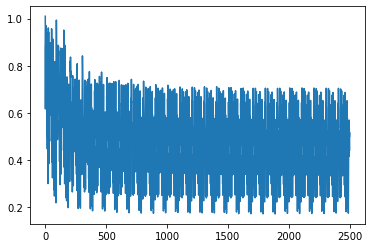

In [245]:
losses, accuracies = train_model(price_model, 
                                 LR=0.05, 
                                 n_epochs=25, 
                                 X_BATCH = np.split(X,100), 
                                 Y_BATCH = np.split(Y, 100)
                                )

plt.plot(losses)

In [246]:
out = price_model(X).detach()

In [247]:
match = torch.max(out,1)[1] == torch.max(Y, 1)[1]
match = match.type(torch.LongTensor)

In [248]:
match.numpy().sum()/len(X)

0.8159519038076152

In [251]:
print(Y[:,0].sum())
print(Y[:,1].sum())
print(Y[:,2].sum())

tensor(5884)
tensor(38222)
tensor(5794)


[[ 2344.  2143.  1397.]
 [  978. 36598.   646.]
 [ 1903.  2117.  1774.]]


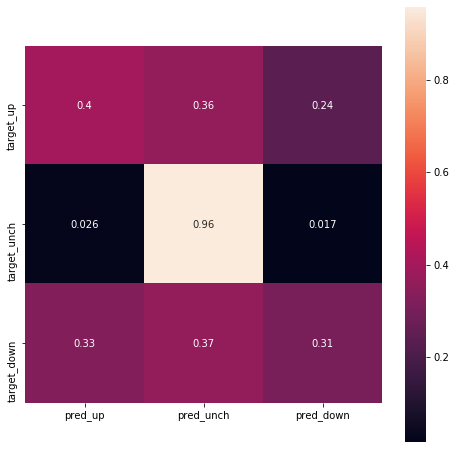

In [280]:
pred = torch.max(out,1)[1].numpy()
target = torch.max(Y,1)[1].numpy()

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(target, pred)
cm = cm.astype(float)

print(cm)

cm[0,:] = np.true_divide(cm[0,:], cm[0,:].sum())
cm[1,:] = np.true_divide(cm[1,:], cm[1,:].sum())
cm[2,:] = np.true_divide(cm[2,:], cm[2,:].sum())


import seaborn as sns

fig, axs = plt.subplots(1, figsize = (8,8))
axs = sns.heatmap(cm, xticklabels=['pred_up','pred_unch', 'pred_down'], 
                  yticklabels=['target_up','target_unch', 'target_down'], annot = True,square=True)